Size of training set: 60000 images.
Size of training set: 10000 images.
Image dimensions: torch.Size([1, 28, 28]).
Image label: 5.


True

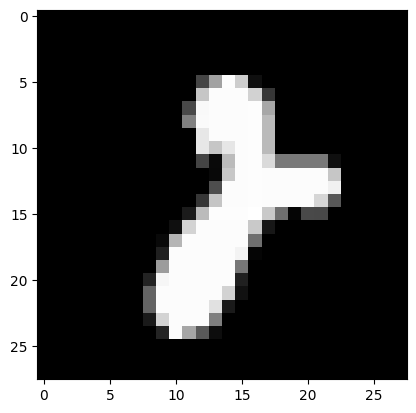

In [77]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.metrics import accuracy_score
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
training_ds = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(), # A quick way to convert the image from PIL image to tensor
)

test_ds = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

class LocalDS(Dataset):
    def __init__(self, data_dir, label_dir, root_dir, transforms):

        self.data_dir = data_dir
        self.label_dir = label_dir
        self.root_dir = root_dir
        self.transforms = transforms

        #Creating path lists
        self.img_paths = os.path.join(self.root_dir, self.data_dir)
        self.label_paths = os.path.join(self.root_dir, self.label_dir)

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx): 
        """
            This is the critical method in this class. It allows us to get 
            an instance by an id.
        """
        img = Image.open(self.img_paths[idx])
        label = label_paths[idx]

        if self.transforms:
            img = self.transforms(img)

        return img, label 

print(f"Size of training set: {len(training_ds)} images.")
print(f"Size of training set: {len(test_ds)} images.")

img, lbl = training_ds[0]
print(f"Image dimensions: {img.shape}.")
print(f"Image label: {lbl}.")

random_id = random.randint(0, len(training_ds))
img, lbl = training_ds[random_id]

img.squeeze().shape
plt.imshow(img.squeeze(), cmap="gray")

lbl

train_dataloader = DataLoader(training_ds, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=128, shuffle=True)

# PyTorch NN Building

class FFNN(nn.Module): # Extending nn.Module allows us to create NNs
    def __init__(self):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)  # Input is 28*28 = 784, output is 128 (can be anything)
        self.fc2 = nn.Linear(128, 512)    # Input is 128 since output of fc1 is 128 
        self.fc3 = nn.Linear(512, 128)    # Input is 512 since output of fc2 is 512
        self.fc4 = nn.Linear(128, 10)     # Input is 128 since output of fc3 is 128, 
                                          #   and output is 10 since there are 10 classes 

    def forward(self, x):
        x = x.view(x.size(0), -1)         # Flattening
        x = F.relu(self.fc1(x))           # We feed the flattened images to to fc1 and perform ReLU   
        x = F.relu(self.fc2(x))           # We do the same for all FC layers
        x = F.relu(self.fc3(x))
        logits = self.fc4(x)              # Finally, we get the predictions from fc4 or the output layer
        return logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

model = FFNN()
model = model.to(device)
model 

criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr = 1e-3)

#Training

def run_epoch(ep_id, action, loader, model, optimizer, criterion):
    accuracies = [] # Keep list of accuracies to track progress
    is_training = action == "train" # True when action == "train", else False 

    # Looping over all batches
    for batch_idx, batch in enumerate(loader): 
            imgs, lbls = batch

            # Sending images and labels to device 
            imgs = imgs.to(device)
            lbls = lbls.to(device)

            # Resetting the optimizer gradients
            optimizer.zero_grad()

            # Setting model to train or test
            with torch.set_grad_enabled(is_training):
                
                # Feed batch to model
                logits = model(imgs)

                # Calculate the loss based on predictions and real labels
                loss = criterion(logits, lbls)

                # Using torch.max() to get the highest prediction
                _, preds = torch.max(logits, 1)

                # Calculating accuracy between real labels and predicted labels
                # Notice that tensors must be on CPU to perform such calculations
                acc = accuracy_score(preds.to('cpu'), lbls.to('cpu'))

                # If training, perform backprop and update weights
                if is_training:
                    loss.backward()
                    optimizer.step()

                # Append current batch accuracy
                accuracies.append(acc)

                # Print some stats every 50th batch 
                if batch_idx % 50 == 0:
                    print(f"{action.capitalize()}ing, Epoch: {ep_id+1}, Batch {batch_idx}: Loss = {loss.item()}, Acc = {acc}")
    # Return accuracies to main loop                 
    return accuracies

def main(epochs, train_dl, test_dl, model, optimizer, criterion):

    # Keep lists of accuracies to track performance on train and test sets
    train_accuracies = []
    test_accuracies = []

    # Looping over epochs
    for epoch in range(epochs):
        
        # Looping over train set and training
        train_acc = run_epoch(epoch, "train", train_dl, model, optimizer, criterion)

        # Looping over test set
        test_acc = run_epoch(epoch, "test", test_dl, model, optimizer, criterion) 

        # Collecting stats
        train_accuracies += train_acc
        test_accuracies += test_acc         
            
    return train_accuracies, test_accuracies
    train_accs, test_accs = main(3, train_dataloader, test_dataloader, model, optim, criterion)

#plt.plot(train_accs)

#plt.plot(test_accs)

# Get a random test image
random_id = random.randint(0, len(test_ds))
img, lbl = training_ds[random_id]

plt.imshow(img.squeeze(), cmap="gray")

lbl

# First, send the image to device
img = img.to(device)

# Feed the image to the model
logits = model(img)

# Get the class with the highest score
_, preds = torch.max(logits, 1)
pred = preds.item()
pred

pred == lbl


#Saving/Loading Models

# Saving current weights:
path = "mnist_model.pt"
torch.save(model.state_dict(), path)
new_model = FFNN()
new_model = new_model.to(device)

logits = new_model(img)
_, preds = torch.max(logits, 1)
pred = preds.item()
pred 
pred == lbl

new_model.load_state_dict(torch.load(path))

logits = new_model(img)
_, preds = torch.max(logits, 1)
pred = preds.item()
pred 

pred == lbl

